In [1]:
from models import NW   
from loaders import load_breast_cancer
import torch
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# A relu network with a single hidden layer, with a 1-dimensional input and output
class SimpleNet(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

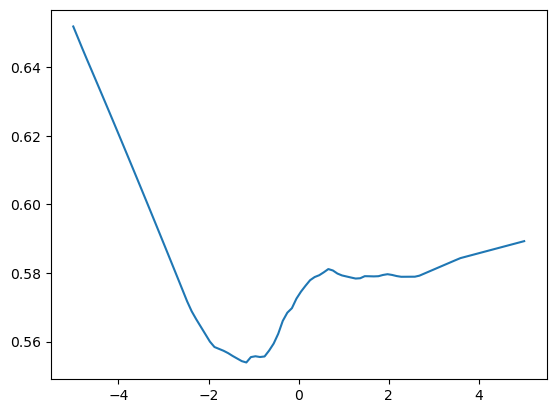

In [3]:
model = SimpleNet(hidden_dim=50)

# Create 100 points in the interval [-5, 5]
X = torch.linspace(-5, 5, 100).reshape(-1, 1)
y = torch.sigmoid(model(X))

# plot X vs y
plt.plot(X, y.detach().numpy())

In [4]:
# A dense layer
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim, activation=torch.tanh):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        return self.activation(x)

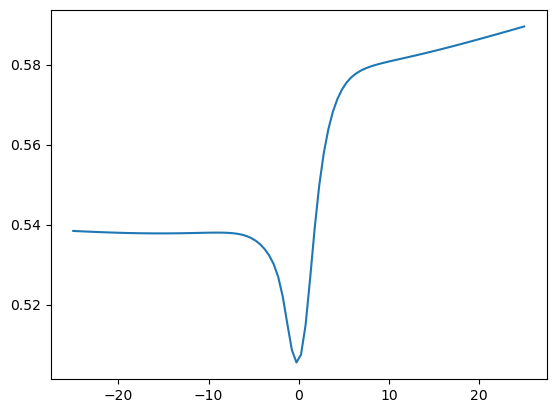

In [5]:
model = nn.Sequential(Dense(1,10), Dense(10,5), Dense(5,1), nn.Sigmoid())

# plot model(x) for x in [-5, 5]
x = torch.linspace(-25, 25, 100).view(-1, 1)
y = model(x)
plt.plot(x, y.detach().numpy())

## Neural Networks on Breast Cancer data

In [12]:
X_train, y_train, X_test, y_test = load_breast_cancer()

# Make X data float
X_train = X_train.float()
X_test = X_test.float()

y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

<AxesSubplot: >

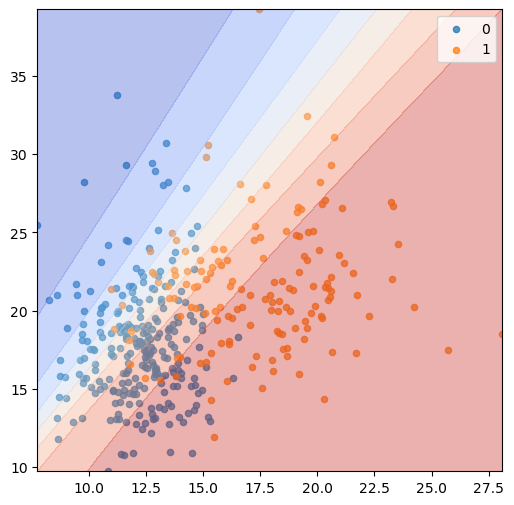

In [13]:
from helpers import train, plot_decision_level_sets

# model = nn.Sequential(SimpleNet(input_dim=2, hidden_dim=10), nn.Sigmoid())
model = nn.Sequential(Dense(2,10),  Dense(10,1), nn.Sigmoid())
plot_decision_level_sets(model, X_train, y_train)

0.3921735882759094

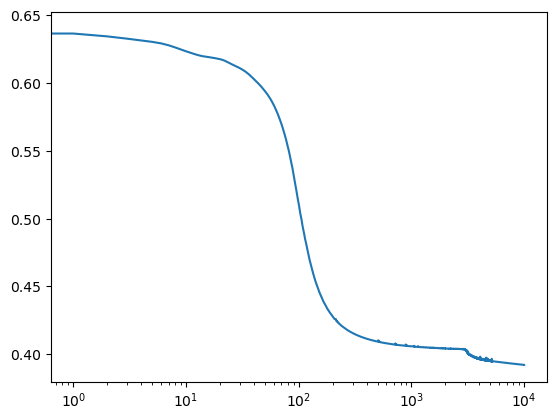

In [15]:
from helpers import gd_with_momentum2

torch.manual_seed(8493)

model = nn.Sequential(Dense(2,10),  Dense(10,1))
# model = nn.Sequential(Dense(2,10),  Dense(10,10), Dense(10,1))
# model = nn.Sequential(Dense(2,10, torch.relu),  Dense(10, 1, torch.relu))

list(model.parameters())

def log_loss(model):
     z = model(X_train) 
     return torch.mean(-y_train * z + torch.log(1 + torch.exp(z)))

# loss_hist = gd_with_momentum2(model, log_loss, momentum=0.9, lr=0.04, n_steps=10000)
# loss_hist = train(model, log_loss, n_steps=20000, lr=5e-3, momentum=0.8)

loss_hist = train(model, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)

# # loss_hist = train(model, F.binary_cross_entropy_with_logits, 1000, lr=0.01)

plt.plot(loss_hist)
# log axis
plt.xscale('log')
loss_hist[-1]

<AxesSubplot: >

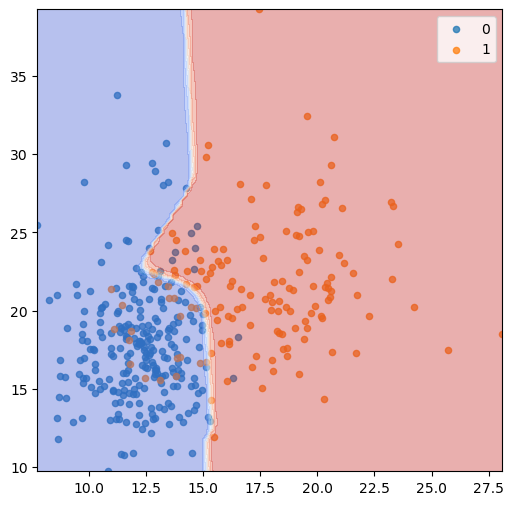

In [16]:
@torch.no_grad()
def wrapped_model(X):
    return torch.sigmoid(model(X))

plot_decision_level_sets(wrapped_model, X_train, y_train)

In [19]:
# accuracy on the test set
with torch.no_grad():
    y_pred = wrapped_model(X_test)
    y_pred = (y_pred > 0.5).float()
    print((y_pred == y_test).float().mean())

tensor(0.8889)


In [20]:
# print model parameters named
for name, param in model.named_parameters():
    print(name, param)

0.fc.weight Parameter containing:
tensor([[ 0.4408,  0.1917],
        [ 0.4533,  0.0493],
        [-3.7838,  2.0864],
        [-0.5216, -0.5573],
        [-0.6826, -0.4337],
        [-3.4531,  4.4757],
        [ 0.2623,  0.5804],
        [-0.4050,  0.5181],
        [-0.3770, -0.0116],
        [ 0.4689,  0.4063]], requires_grad=True)
0.fc.bias Parameter containing:
tensor([ 0.4034,  0.4953, -2.7550,  0.3230,  0.2445, -1.2004,  0.0901, -5.7872,
         5.8419, -0.1989], requires_grad=True)
1.fc.weight Parameter containing:
tensor([[ 1.1266e-01, -5.5432e-02, -9.0591e+00,  1.5505e-01, -2.4183e-03,
         -1.2113e+00,  1.3056e-01,  1.0434e+01, -2.2118e+01,  1.0216e-01]],
       requires_grad=True)
1.fc.bias Parameter containing:
tensor([0.3068], requires_grad=True)
